# AMATH 581 Final Project - Computational Notebook

In [1]:
# Import libraries
import numpy as np
import scipy.integrate
import scipy.sparse
import scipy.optimize
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from matplotlib import cm

## Ordinary Differential Equations - Initial Value Problem Solvers

### Van der Pol Oscillator

The physical system we are interested in examining for initial value problems is the Van der Pol oscillator, given by
$$\frac{d^2 y(t)}{dt^2} + \epsilon (y^2(t) - 1) \frac{dy}{dt} + y(t) = 0$$
where $\epsilon$ is a parameter indicating the strength of the nonlinearity in the system.

In [2]:
# Define ODE
dydt = lambda t, y, eps: np.array([y[1], -eps*(y[0]**2 -1)*y[1] - y[0]])

Using $\epsilon = [0.1, 1, 20]$, $y(t = 0) =  3$, and $\frac{dy}{dt}(t = 0) = 1$, we solve the equation for $t \in [0, 32]$ with $\Delta t = 0.5$ using the explicit Runge-Kutta method of order 4(5).

In [3]:
# Define initial condition and range of time values
y0 = np.array([np.sqrt(3), 1])
trange = np.arange(0, 32.5, 0.5)

# Solve for varying epsilon
out1 = scipy.integrate.solve_ivp(lambda t,y: dydt(t, y, 0.1), [0, 32], y0, t_eval = trange) # epsilon = 0.01
out2 = scipy.integrate.solve_ivp(lambda t,y: dydt(t, y, 1), [0, 32], y0, t_eval = trange) # epsilon = 1.0
out3 = scipy.integrate.solve_ivp(lambda t,y: dydt(t, y, 20), [0, 32], y0, t_eval = trange) # epsilon = 20.0
A10 = np.array([out1.y[0], out2.y[0], out3.y[0]]).T

We can perform the previous computation but with adaptive time stepping to to reach error goals for both relative and absolute error.

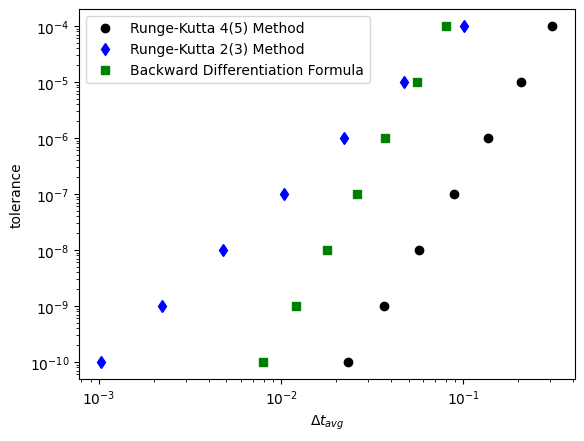

In [4]:
# Define initial condition and tolerance array
y0 = np.array([2, np.pi**2])
tolerances = np.logspace(-4, -10, 7)

# Initialize empty arrays for iteration
t1_diff = np.zeros(len(tolerances))
t2_diff = np.zeros(len(tolerances))
t3_diff = np.zeros(len(tolerances))

for iter, tol in enumerate(np.logspace(-4, -10, 7)):
    # Using the Runge-Kutta 4(5) method
    out1 = scipy.integrate.solve_ivp(lambda t, y: dydt(t, y, 1), [0, 32], y0, method='RK45', atol=tol, rtol=tol)
    t1 = out1.t
    t1_diff[iter] = np.mean(np.diff(t1))

    # Using the Runge-Kutta 2(3) method
    out2 = scipy.integrate.solve_ivp(lambda t,y: dydt(t, y, 1), [0, 32], y0, method='RK23', atol = tol, rtol = tol)
    t2 = out2.t
    t2_diff[iter]  = np.mean(np.diff(t2))

    # Using the backward differentiation formula
    out3 = scipy.integrate.solve_ivp(lambda t,y: dydt(t, y, 1), [0, 32], y0, method='BDF', atol = tol, rtol = tol)
    t3 = out3.t
    t3_diff[iter] = np.mean(np.diff(t3))

# Apply a polyfit of degree 1
A11 = np.polyfit(np.log(t1_diff), np.log(tolerances), 1)[0]
A12 = np.polyfit(np.log(t2_diff), np.log(tolerances), 1)[0]
A13 = np.polyfit(np.log(t3_diff), np.log(tolerances), 1)[0]

plt.figure()
plt.loglog(t1_diff, tolerances, 'ko', label='Runge-Kutta 4(5) Method')
plt.loglog(t2_diff, tolerances, 'bd', label='Runge-Kutta 2(3) Method')
plt.loglog(t3_diff, tolerances, 'gs', label='Backward Differentiation Formula')
plt.xlabel('$\Delta t _{avg}$')
plt.ylabel('tolerance')
plt.legend()

We can observe from the results of our log-log plot that the Backward Differentiation Formula (BDF) solver has the highest order of accuracy as the relative/absolute tolerances increase. More trivially, the Runge-Kutta 4(5) method is more accurate than the Runge-Kutta 2(3) method, as we would expect.

Text(0, 0.5, 'y(t)')

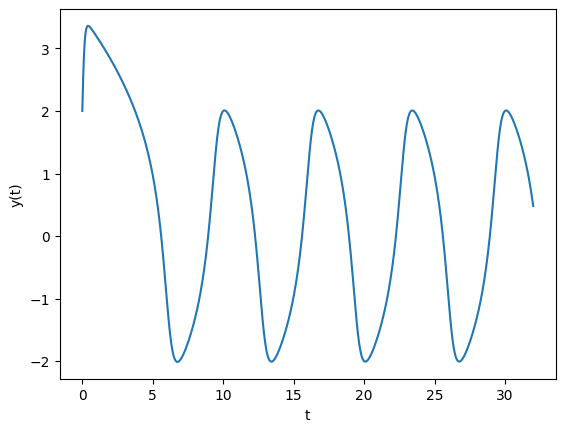

In [5]:
plt.figure()
plt.plot(out1.t, out1.y[0,:])
plt.xlabel('t')
plt.ylabel('y(t)')

We can also see the periodic nature of the solution to the Van der Pol oscillator. The solutions of this ordinary differential equation exhibit non-linear damping as $t \longrightarrow \infty$. As mentioned earlier, the strength and nonlinearity of this damping is determined by $\epsilon$.

## Ordinary Differential Equations - Boundary Value Problem Solvers

### Quantum Harmonic Oscillator

The physical system we are interseted in examining for boundary value problems is the Quantum Harmonic Oscillator, given by
$$i \hbar \psi_{t} + \frac{\hbar^{2}}{2m} \psi_{xx} - V(x) \psi = 0$$
where $\psi$ is the probability density, $m$ is the mass, $\hbar$ is Planck's constant, and $V(x) = \frac{kx^2}{2}$ is the harmonic confining potential. A typical solution technique for this problem is to assume a solution of the form
$$\psi(x,t) = \sum_{n=1}^{N}a_{n} \phi_{n}(x) \exp \left(-i \frac{E_{n}}{2 \hbar}t \right)$$
This technique is called an eigenfunction expansion solution where $\phi_{n}$ is an eigenfunction and $E_n>0$ is the corresponding eigenvalue. Plugging this ansatz into the harmonic potential PDE gives the boundary value problem 
$$\frac{d^2 \phi_{n}}{dx^2} - [Kx^2 - \epsilon_{n}] \phi_{n} = 0$$

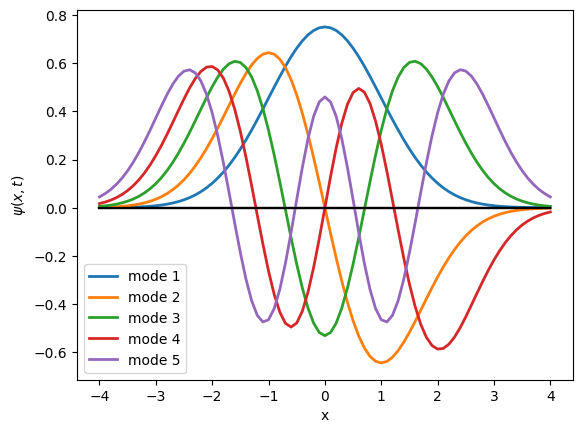

In [6]:
def rhsfunc1(t, y, eps):
    """Right-hand side function for vectorizing initial condition"""
    f1 = y[1]
    f2 = (t**2 - eps)*y[0]
    return np.array([f1, f2])

# Define our tolerance and initial guess for first shot of shooting method
xp = [-4, 4]
tol = 1e-6
A = 1

x_evals = np.linspace(-4, 4, 81)
eps_start = 0

# Initialize empty arrays for iteration
eigenvalues1 = np.zeros(5)
eigenfunctions1 = np.zeros([81, 5])
phi = np.zeros([81, 5])

# Iteratively perform root finding on right boundary and update shooting angle
for mode in range(5):
    eps = eps_start
    deps = 1
    
    for i in range(1000):
        y0 = np.array([A, A*np.sqrt(4**2 - eps)])
        sol = scipy.integrate.solve_ivp(lambda x, y: rhsfunc1(x, y, eps), xp, y0, t_eval = x_evals)

        if (np.abs(sol.y[1, -1] + np.sqrt(4**2 - eps)*sol.y[0, -1])) < tol:
            eigenfunctions1[:, mode] = sol.y[0, :]
            eigenvalues1[mode] = eps
            break

        if (-1)**(mode)*(sol.y[1, -1] + np.sqrt(4**2 - eps)*sol.y[0, -1]) > 0:
            eps = eps + deps
        else:
            eps = eps - deps/2
            deps = deps/2
    
    eps_start = eps + 0.1
    eig_norm = np.trapz(eigenfunctions1[:, mode]**2, x = x_evals)
    eigenfunctions1[:, mode] = eigenfunctions1[:, mode]/np.sqrt(eig_norm)
    
    plt.plot(sol.t, eigenfunctions1[:, mode], linewidth=2, label='mode ' + str(mode + 1))
    plt.plot(sol.t, 0*sol.t, 'k')

    phi[:, mode] = eigenfunctions1[:, mode]
    eigenfunctions1[:, mode] = abs(eigenfunctions1[:, mode])

plt.xlabel('x')
plt.ylabel('$\psi(x, t)$')
plt.legend()

A1 = eigenfunctions1[:, 0].reshape(-1, 1)
A2 = eigenfunctions1[:, 1].reshape(-1, 1)
A3 = eigenfunctions1[:, 2].reshape(-1, 1)
A4 = eigenfunctions1[:, 3].reshape(-1, 1)
A5 = eigenfunctions1[:, 4].reshape(-1, 1)
A6 = eigenvalues1.reshape(1, -1)

This plot shows the 5 eigenfunctions, each with an aditional zero compared the previous iteration.

Text(0.5, 0.92, 'Time Evolution of Probability Density Function $\\psi_2(x, t)$')

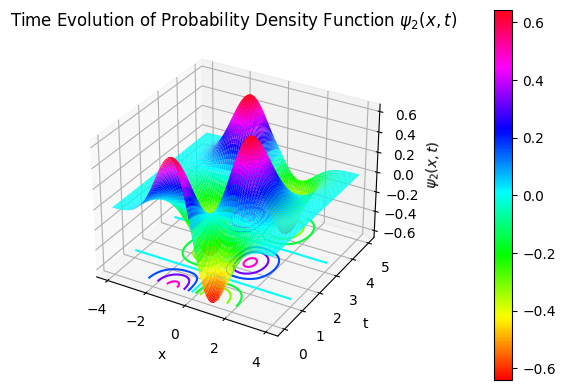

In [7]:
# Define x and t discretization
x = np.linspace(-4, 4, 81)
t = np.linspace(0, 5, 100)

fig = plt.figure()
ax = plt.axes(projection = '3d')
density = (phi[:, 1].reshape(-1, 1) * np.cos(eigenvalues1[1]*t/2)).T

# Initialize x-t mesh
X, T = np.meshgrid(x, t)
surf = ax.plot_surface(X, T, density, cmap = cm.hsv, rstride=1, cstride=1)
fig.colorbar(surf, pad = 0.2)
ax.contour(X, T, density, cmap = cm.hsv, offset = -0.6)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel(r'$\psi_2(x, t)$')
plt.title(r'Time Evolution of Probability Density Function $\psi_2(x, t)$')

Here we can observe the 3-dimensional plot of our probability density function for the second mode, $\psi_2(x, t)$, with respect to its spacial and temporal components.

## Comparison: IVPs Versus BVPs

It is important to distinguish when a problem calls for the use of an initial value problem solver or boundary value problem solver. Ultimately it is dependent on which of the two categories the the problem falls into, which in turn, is dependent on the problem's side conditions. A side condition is an initial condition if it prescribes what happens to our function at one point in time. An example of an initial condition would be the value of the function and it derivative at some time $t$. A side condition is a boundary condition if it prescribes what happens to the function on the boundary of some domain we are interested in. An example of a boundary condition in 1D is the endpoints of our domain.

## Partial Differential Equations - Finite Difference

### Advection Equation

The physical system we are interested in examining for finite difference methods is the advection equation. The advection equation is partial differential equation which models the flow of a specific quantity, $u = u(x,t)$ as it is advected by a velocity field, $c$. The velocity field
may be nonconstant. For instance, the velocity field may come from a
periodic source such as waves reaching the beach. In this problem we
will consider the 1D advection equation,
$$
u_t + c(x, t) u_x = 0 \quad -\infty<x<\infty, ~ t>0
$$
with initial condition
$$
u(x,0) = e^{-(x-5)^2}
$$

First we setup the matrix $A \approx \partial_x$ using second-order central differences and sparse storage.

In [8]:
x_evals = np.arange(-10, 10, 0.1)
n = 200
b = np.ones((n))
Bin = np.array([-b, b, -b, b])
d = np.array([-1, 1, n-1, 1-n])
matrix1 = scipy.sparse.spdiags(Bin, d, n, n, format='csc')/(2*0.1)
A1 = matrix1.todense()

We solve the advection equation with $c(x,t) = -0.5$, this corresponds to a constant velocity field. In other words, solve $u_t = 0.5 A u$.

In [9]:
u0 = np.exp(-(x_evals-5)**2)
def advection1(t, u, A, c):
    return -c*(A@u)

sol1 = scipy.integrate.solve_ivp(advection1, [0, 10], u0, t_eval = np.arange(0, 10 + 0.5, 0.5), args = (matrix1, -0.5))
A2 = sol1.y

Text(0.5, 0.92, 'Constant Velocity Field')

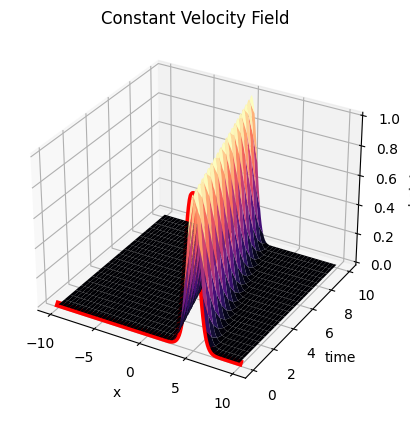

In [10]:
X, T = np.meshgrid(x_evals, sol1.t)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, T, sol1.y.T, cmap='magma')
ax.plot3D(x_evals, 0*x_evals, u0,'-r', linewidth=5)
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('height')
ax.set_title('Constant Velocity Field')

We are also interested in using a non-constant $c(x,t)$. We solve the advection equation with
$$c(x,t) = -\left(1 + 2\sin(5t) - H(x-4)\right)$$
where $H(z)$ is the Heaviside function given by
$$H(z) = \begin{cases} 1, & z>0 \\ 0,& z\leq 0\end{cases}$$

In [11]:
def advection2(t, u, A, cFunc, x):
    c = cFunc(t, x)
    return c*(A@u)

def cFunc(t, x):
    return (1 + 2*np.sin(5*t) - np.heaviside(x - 4, 0))

sol2 = scipy.integrate.solve_ivp(advection2, [0, 10], u0, t_eval = np.arange(0, 10 + 0.5, 0.5), args = (matrix1, cFunc, x_evals))
A3 = sol2.y

Text(0.5, 0.92, 'Variable (Nonconstant) Velocity Field')

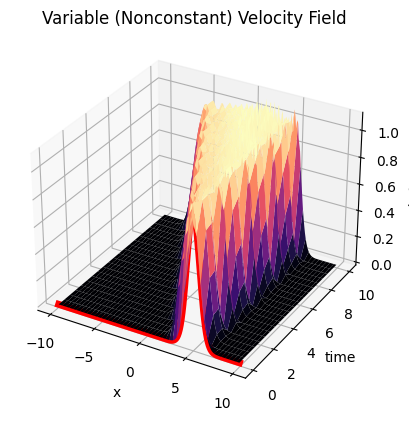

In [12]:
X, T = np.meshgrid(x_evals, sol2.t)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, T, sol2.y.T, cmap='magma')
ax.plot3D(x_evals, 0*x_evals, u0,'-r', linewidth=5)
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('height')
ax.set_title('Variable (Nonconstant) Velocity Field')

## Comparison: When Are Finite Difference Methods Advantageous?

Finite Difference methods convert ordinary differential equations or partial differential equations, which may be nonlinear, into a system of linear equations that can be solved by matrix algebra techniques. This allows Finite Difference methods to converge to numerical solutions for solving nonlinear systems where IVP and BVP solvers would not be able to. If the differential equation is nonlinear, the algebraic equations will also be nonlinear.

## Stability

### Heat Equation

The physical system we are interested in studying is the heat conduction on a thin circular ring. To model this, we use the heat equation with periodic boundary conditions,
$$u_t = \alpha u_{xx}, \qquad x\in [-L, L], \quad t>0,\\$$
$$u(x, 0) = f(x) = 10\cos\left(\frac{2\pi x}{L}\right) + 30 \cos \left(\frac{8\pi x}{L}\right), \quad x\in [-L, L],$$
$$u(-L, t) = u(L, t), \qquad t>0,$$
$$u_x(-L, t) = u_x(L, t) , \qquad t>0.$$
We can think about this PDE as taking a thin rod of length $2L$ and bending it to attach the two ends together. The first periodic boundary condition says that the temperature at the connection must be continuous and the second periodic boundary condition says that the temperature flux at the connection must also be continuous.

The first scheme we will consider is a (1st-order time, 4th-order space)-accurate scheme. We can derive this scheme using the fourth-order centered differences approximation for the second derivative and Forward-Euler in time. The resulting scheme will be
$$
\vec u^{m+1} = \vec u^m + \lambda D_4 \vec u^m
$$
This method is not always stable. To verify that, we find the magnification factor $g(z; \lambda)$ and plot $|g(z; \lambda)|$ for $\lambda \in [0, 3]$ and for $z \in [-\pi, \pi)$. We are going to find the largest $\lambda > 0$ for which the method is
stable. To do so, loop over $\lambda$ values from $0$ to $1$ with step size $0.01$ and find the maximum of $g(z; \lambda)$ on $z\in [\pi/2,\pi]$ for each $\lambda$ using the fminbound function.

In [13]:
x = np.linspace(-10, 10, 128, endpoint=False)
dx = 20/128
t = np.linspace(0, 2, 501)
dt = 2/500
CFL = (2*dt)/(dx)**2
g1 = lambda z: 1 + (CFL/12)*(32*np.cos(z) - 2*np.cos(2*z) - 30)
A1 = abs(g1(1))
A1

0.6756505247982867

Now that we have formulated our magnification factor $g(z; \lambda)$. We use the fminbound function to find the largest $\lambda > 0$ for which the method is stable. Once we have found the index of the largest $\lambda$ on $[\pi/2,\pi]$, we can find the maximum of $|g(z; \lambda^*)|$.

In [14]:
min_index1 = scipy.optimize.fminbound(lambda z: -abs(g1(z)), -np.pi, np.pi)
A2 = g1(min_index1)
A2

1.0

Now that we have verified the stability of the (1,4)-method, we can continue solving the heal equation using a 4th-order accurate center-difference scheme for the second derivative to create our spatial discretization matrix.

In [15]:
# Define number of points for discretization and generate matrix
n = 128
e = np.ones(n)
matrix1 = scipy.sparse.spdiags([16*e, -e, -e, 16*e, -30*e, 16*e, -e, -e, 16*e], [1-n, 2-n, -2, -1, 0, 1, 2, n-2, n-1], n, n, format='csc')/12
A3 = matrix1.todense()
A4 = 0

Finally we can find the solution to our heat equation as $t = 2$, which is a column vector of length 128 due to us using 128 equally space points for our discretization.

In [16]:
sol1 = np.zeros((len(x), len(t)))
u0 = 10*np.cos(2*np.pi*x/10) + 30*np.cos(8*np.pi*x/10)
sol1[:, 0] = u0
for i in range(int(2/dt)):
    u1 = u0 + CFL*(matrix1@u0)
    u0 = u1
    sol1[:, i+1] = u1

A5 = sol1[:, -1].reshape(-1, 1)
A5[:10]

array([[2.05638808],
       [2.04648601],
       [2.01687516],
       [1.9678407 ],
       [1.89985486],
       [1.81357238],
       [1.7098242 ],
       [1.58960949],
       [1.45408596],
       [1.30455879]])

## Fast Fourier Transform

### Reaction–Diffusion System

To discuess the Fast Fourier transform, we will be examining a reaction-diffusion system. A reaction-diffusion system for the two quantities $U(x, y, t)$ and $V(x,y,t)$, can be modeled by
$$
U_{t} = \lambda(A)U-\omega(A)V+D_{1}\nabla^2U
$$
$$
V_{t} = \omega(A)U-\lambda(A)V+D_{2}\nabla^2V
$$
where $A^2=U^2+V^2$ and $\nabla^2=\partial_{x}^2+\partial_{y}^2$. We will consider a particular system with
$$
\lambda(A) = 1-A^2
$$
$$
\omega(A) = -\beta A^2,
$$
We will study this reaction-diffusion system with the spiral initial condition
$$
U(x,y,0) = \left(\tanh(\sqrt{x^2 + y^2} - \alpha)\right)\cos\left( a(x,y)m - \sqrt{x^2+y^2}\right)
$$
$$
V(x,y,0) = \left(\tanh(\sqrt{x^2 + y^2} - \alpha)\right)\sin\left( a(x,y)m - \sqrt{x^2+y^2}\right)
$$
where $a(x,y)$ is the angle between the $x$ axis and the complex number $x + iy$.

In [17]:
# Initialize x-y mesh
x = np.linspace(-10, 10, 64, endpoint=False)
y = np.linspace(-10, 10, 64, endpoint=False)
X, Y = np.meshgrid(x, y)

# Define initial conditions
m = 3
alpha = 0
n = 64
u = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.cos(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
v = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.sin(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
A1 = X
A2 = u

# Transform into Fourier domain
u0 = fft2(u)
v0 = fft2(v)
A3 = u0.real

# Append initial conditions
u0 = u0.reshape(-1, 1, order='F')
v0 = v0.reshape(-1, 1, order='F')
vec0 = np.concatenate((u0, v0))
A4 = vec0.imag

def rhs1(t, n, vec, beta, KX, KY):
    """Right-hand side function to return Fourier transform of the solution"""
    u_hat = vec[:4096].reshape(n, n, order='F')
    v_hat = vec[4096:].reshape(n, n, order='F')

    # Transform out of Fourier domain
    u = ifft2(u_hat)
    v = ifft2(v_hat)

    u_nl = u - u**3 - u*v**2 + beta*(v*u**2 + v**3)
    v_nl = -beta*(u**3 + u*v**2) - v + v*u**2 + v**3

    u_t = fft2(u_nl) - 0.1*((KX**2)*u_hat + (KY**2)*u_hat)
    v_t = fft2(v_nl) - 0.1*((KX**2)*v_hat + (KY**2)*v_hat)

    u_t = u_t.reshape(n**2, order='F')
    v_t = v_t.reshape(n**2, order='F')
    rhs = np.concatenate((u_t, v_t), axis=0)

    return rhs

In [18]:
t_span = np.linspace(0, 25, 51)
r1 = np.arange(0, n/2, 1)
r2 = np.arange(-n/2, 0, 1)
kx = (2*np.pi/20)*np.concatenate((r1, r2))
ky = kx.copy()
KX, KY = np.meshgrid(kx, ky)
beta = 1

# Timestep using the explicit Runge-Kutta method of order 4(5)
sol1 = scipy.integrate.solve_ivp(lambda t, vec: rhs1(t, n, vec, beta, KX, KY), [0, 25], np.squeeze(vec0), t_eval = t_span)
A5 = sol1.y.real
A6 = sol1.y.imag
A7 = sol1.y.real[:4096][:, 4].reshape(-1, 1)
A8 = sol1.y.real[:4096][:, 4].reshape(n, n, order='F')
A9 = ifft2(sol1.y[:4096][:, 4].reshape(n, n, order='F')).real
A9[:10, 0]

array([-0.3016566 , -0.64475668, -0.75494739, -0.79196993, -0.82652957,
       -0.85136787, -0.84566054, -0.79611449, -0.69842677, -0.56194496])

## Spectral Methods

To discuess the Spectral methods, we will be examining the same reaction-diffusion system we looked at for the Fast Fourier transform with Dirichlet Boundary conditions,
$$
U(x=-10, y, t) = U(x=10, y, t) = U(x, y=-10, t) = U(x, y=10, t) = 0,
$$
using the Chebyshev pseudo-spectral method. To do so, set $m=2$, $\alpha = 1$, and use $n=30$ when creating the Chebyshev matrix and Chebyshev points. You should use the functions I provided for creating the matrix and points.

First we must define our Chebyshev function to create our differentiation matrix.

In [19]:
def cheb(N):
    if N == 0:
        D = 0
        x = 1
        return D, x
    vals = np.linspace(0, N, N+1)
    x = np.cos(np.pi*vals/N)
    x = x.reshape(-1, 1)
    c = np.ones(N - 1)
    c = np.pad(c, (1,), constant_values=2)
    c *= (-1)**vals
    c = c.reshape(-1, 1)
    X = np.tile(x, (1, N + 1))
    dX = X - X.T
    D  = (c*(1/c.T))/(dX + (np.eye(N + 1)))
    D  = D - np.diag(sum(D.T))

    return D, x

We can now roughly recreate our numerical process from the previous problem to incorporate our Chebyshev points.

In [20]:
# Define initial conditions
m = 2
alpha = 1
n = 30

# Create the Chebyshev differentiation matrix
[D, x] = cheb(n)
x = 10*x.reshape(n + 1)
D2 = D@D
D2 = D2[1:-1, 1:-1]/100

# Scale Laplacian
I = np.eye(len(D2))
Lap = np.kron(D2, I) + np.kron(I, D2)
A10 = Lap

# Create the Chebyshev points
x2 = x[1:-1]
y2 = x2.copy()
[X, Y] = np.meshgrid(x2, y2)
A11 = Y

In [21]:
u = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.cos(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
v = (np.tanh(np.sqrt(X**2 + Y**2)) - alpha)*np.sin(m*np.angle(X + 1j*Y) - np.sqrt(X**2 + Y**2))
A12 = v

# Append initial conditions
u = u.reshape(-1, 1, order='F')
v = v.reshape(-1, 1, order='F')
vec1 = np.concatenate((u, v), axis=0)
A13 = vec1

def rhs2(t, vec, beta, Lap):
    """"Right-hand side function to solve our PDE"""
    u = vec[:841]
    v = vec[841:]

    u_nl = u - u**3 - u*v**2 + beta*(v*u**2 + v**3)
    v_nl = -beta*(u**3 + u*v**2) - v + v*u**2 + v**3

    u_t = u_nl + 0.1*(Lap@u)
    v_t = v_nl + 0.1*(Lap@v)

    rhs = np.concatenate((u_t, v_t), axis=0)

    return rhs

# Timestep using the explicit Runge-Kutta method of order 4(5)
sol2 = scipy.integrate.solve_ivp(lambda t, vec: rhs2(t, vec, beta, Lap), [0, 25], np.squeeze(vec1), t_eval = t_span)
A14 = sol2.y.T
A15 = sol2.y.real[841:][:, 4].reshape(-1, 1)
A16 = np.pad(A15.reshape(29, 29).T, [1, 1])
A16[:5, :5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.35078430e-05,  2.67971733e-06,
        -4.85856742e-07,  1.02740221e-07],
       [ 0.00000000e+00,  2.67961645e-06, -5.29421996e-07,
         7.98422892e-08, -8.19398144e-09],
       [ 0.00000000e+00, -4.85482821e-07,  7.97687116e-08,
        -1.85122520e-08, -1.04839666e-08],
       [ 0.00000000e+00,  1.02226848e-07, -8.06062880e-09,
        -1.06200441e-08,  2.01333387e-08]])

## Comparison: Finite Element Versus Spectral Methods

The key difference between these methods is that Spectral methods are not effective on complex or difficult geometries such as abnormal and rounded shapes. It is important to note that finite difference methods are ineffective for such problems because they would not be able to effectively capture the boundary using an equally spaced grid. An example of a situation where Spectral methods are effective/prefered is on a perfect circle, where Chebyshev polynomials would be able to capture the entire geometry including the boundary. The objective when using Spectral methods is to write the solution of the differential equation as a sum of certain basis functions and then to choose the coefficients in the sum in order to satisfy the differential equation as well as possible. However, any added complexities such as adding a hole in the geometry would require the use of Finite Element methods.